# Data Science and Machine Learning - Programm a Spam/Ham Classifier

In [69]:
##install modules
#%pip install numpy pandas scikit-learn nltk matplotlib
#%pip freeze > requirements.txt

In [70]:
#import modules
import os
import numpy as np
import pandas as pd

## Preprocessing

First the data has to be loaded in and undergo some preprocessing.
The data was downloaded from [Apache Spam Assassin](https://spamassassin.apache.org/old/publiccorpus/) and got extracted into the `data` folder.

With the `os` module we'll iterate through all the directories in the data folder and load the files with labels into a `pandas` dataframe.

The data folder stucture looks as follows:
```plaintext
data/
├── easy_ham
├── easy_ham_2
├── hard_ham
├── spam
└── spam_2
```

In [71]:
def load_emails(data_folder):
    """""Load emails from the specified folder.

    Args:
        data_folder (string): path to the folder containing email data.

    Returns:
        DataFrame: DataFrame containing labelled emails.
    """""
    emails = []
    for data in os.listdir(data_folder):
        dir_path = os.path.join(data_folder, data)
        if 'ham' in dir_path:
            for filename in os.listdir(dir_path):
                file_path = os.path.join(dir_path, filename)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='latin-1') as f:
                        content = f.read()
                        emails.append((content, 0))
        elif 'spam' in data:
            for filename in os.listdir(dir_path):
                file_path = os.path.join(dir_path, filename)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='latin-1') as f:
                        content = f.read()
                        emails.append((content, 1))
    return pd.DataFrame(emails, columns=['text', 'is_spam']) 

df_emails = load_emails("data")
df_emails.head()

,text,is_spam
0,From atoffd1@aol.com Mon Jun 24 17:04:34 2002...,1
1,From twoods35@yahoo.com Mon Jun 24 17:05:08 2...,1
2,From rwuma@mailasia.com Mon Jul 29 11:22:08 2...,1
3,From matty@hurra.de Tue Jul 30 09:30:50 2002\...,1
4,From customerservice2217p83@spc.com Mon Jun 2...,1


Now that the dataset is labeled as `spam` or `ham` it can be shuffeled and split into training and test sets.

In [72]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_emails, random_state=42, shuffle= True)
print(f"{train_data.head()}, \n\n{test_data.head()}")

                                                   text  is_spam
3264  Return-Path: guido@python.org\nDelivery-Date: ...        0
43    From info@ipogea.com  Mon Jun 24 17:46:35 2002...        1
4954  From fork-admin@xent.com  Wed Jul 24 13:20:12 ...        0
5599  From fork-admin@xent.com  Tue Aug  6 11:58:27 ...        0
5391  From fork-admin@xent.com  Tue Aug 20 22:51:27 ...        0, 

                                                   text  is_spam
2794  Return-Path: tim.one@comcast.net\nDelivery-Dat...        0
2592  From rssfeeds@jmason.org  Thu Sep 26 16:42:15 ...        0
5356  From rpm-list-admin@freshrpms.net  Tue Jul 30 ...        0
2002  From rssfeeds@jmason.org  Mon Sep 30 13:37:18 ...        0
4205  From spamassassin-talk-admin@lists.sourceforge...        0


To make it easier to for the classifier to work with the emails some cleaning up is required, the EmailCleaner class does just that. It makes everything lowercase, removes punctuation and special characters, replaces URL's (" URL ") and numbers (" NUMBER ") with a placeholder, applies stemming and strips of the header.

`EmailCleaner` class uses some functions from the `nltk` modul to achive a cleaned up version of the input email for the classifier.

In [73]:
import re, string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin

URL_RE = re.compile(r"https?://\S+")
NUM_RE = re.compile(r"\b\d+\b")

class EmailCleaner(BaseEstimator, TransformerMixin):
    def __init__(self,
                 strip_headers=True,
                 lowercase=True,
                 remove_punct=True,
                 replace_urls=True,
                 replace_numbers=True,
                 stemming=True):
        self.strip_headers   = strip_headers
        self.lowercase       = lowercase
        self.remove_punct    = remove_punct
        self.replace_urls    = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming        = stemming
        self.stemmer         = PorterStemmer()
        self.lemmatizer      = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._clean_email(text) for text in X]

    def _clean_email(self, text):
        if self.strip_headers:
            parts = text.split('\n\n', 1)
            if len(parts) > 1:
                text = parts[1]

        if self.lowercase:
            text = text.lower()

        if self.replace_urls:
            text = URL_RE.sub(" URL ", text)

        if self.replace_numbers:
            text = NUM_RE.sub(" NUMBER ", text)

        if self.remove_punct:
            text = text.translate(str.maketrans("", "", string.punctuation))

        tokens = word_tokenize(text)

        if self.stemming:
            tokens = [self.stemmer.stem(t) for t in tokens]

        return " ".join(tokens)

# Training
Now that the preprocessing is done, the training of the classifier can begin.

Since the Machine Learning algorithms work with numbers, we need to convert the text into a numerical representation. For a spam classifier, a common approach is the use of the **Bag of Words** model. This model represents text data as a matrix of word counts or frequencies.

To make this more efficient and automated, we can use a `Pipeline` from the `sklearn` libary. The `Pipeline` allows us to chain together multiple processing steps.
In this case the `Pipeline` will consist of the `EmailCleaner` class and a `CountVectorizer` to convert the cleaned text into a numerical representation.
Then a classifier of choice can be added.

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

tree_pipeline = Pipeline([
    ('emailcleaner', EmailCleaner()),
    ('countvectorizer', CountVectorizer()),
    ('classifier', DecisionTreeClassifier())
])

SVC_pipeline = Pipeline([
    ('emailcleaner', EmailCleaner()),
    ('countvectorizer', CountVectorizer()),
    ('classifier', SVC(kernel='linear'))
])

logisticregression_pipeline = Pipeline([
    ('emailcleaner', EmailCleaner()),
    ('countvectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

MLP_pipeline = Pipeline([
    ('emailcleaner', EmailCleaner()),
    ('countvectorizer', CountVectorizer()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
])

multinomialNB_pipeline = Pipeline([
    ('emailcleaner', EmailCleaner()),
    ('countvectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

Now the created `Pipelines` just need to be trained with the training data and can then be used to predict the labels of the test data.

In [75]:
train_data["is_spam"] = train_data["is_spam"].astype(int)
test_data["is_spam"]  = test_data["is_spam"].astype(int)

tree_pipeline.fit(train_data["text"], train_data["is_spam"])
y_pred_tree = tree_pipeline.predict(test_data["text"])

SVC_pipeline.fit(train_data["text"], train_data["is_spam"])
y_pred_SVC = SVC_pipeline.predict(test_data["text"])

logisticregression_pipeline.fit(train_data["text"], train_data["is_spam"])
y_pred_logistic_regression = logisticregression_pipeline.predict(test_data["text"])

MLP_pipeline.fit(train_data["text"], train_data["is_spam"])
y_pred_MLP = MLP_pipeline.predict(test_data["text"])

multinomialNB_pipeline.fit(train_data["text"], train_data["is_spam"])
y_pred_mulinomialNB = multinomialNB_pipeline.predict(test_data["text"])

/home/kevidor/dev/Data_Science/Daniel_McG/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Visualization
Here we visualize the data from the different classifiers and models to see how they perform.

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Tree Classification Report:

              precision    recall  f1-score   support

         ham       0.95      0.96      0.96      1020
        spam       0.93      0.90      0.91       506

    accuracy                           0.94      1526
   macro avg       0.94      0.93      0.94      1526
weighted avg       0.94      0.94      0.94      1526



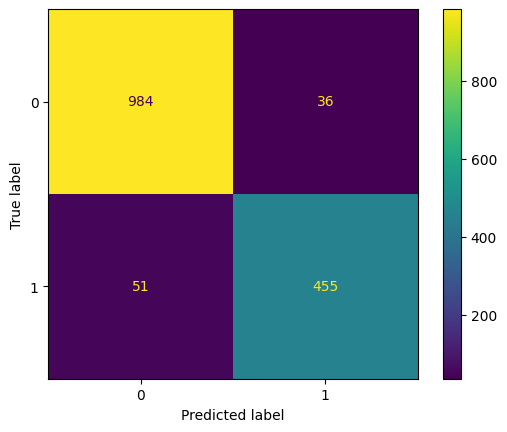

In [77]:
print("Tree Classification Report:\n")
print(classification_report(test_data["is_spam"], y_pred_tree, target_names=["ham", "spam"]))
disp = ConfusionMatrixDisplay(confusion_matrix(test_data["is_spam"], y_pred_tree))
disp.plot()
plt.show()

SVC Classification Report:

              precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1020
        spam       0.97      0.94      0.95       506

    accuracy                           0.97      1526
   macro avg       0.97      0.96      0.97      1526
weighted avg       0.97      0.97      0.97      1526



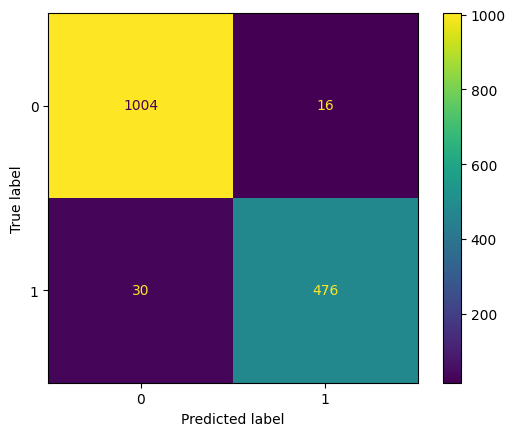

In [78]:
print("SVC Classification Report:\n")
print(classification_report(test_data["is_spam"], y_pred_SVC, target_names=["ham", "spam"]))
disp = ConfusionMatrixDisplay(confusion_matrix(test_data["is_spam"], y_pred_SVC))
disp.plot()
plt.show()

Logistic Regression Classification Report:

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1020
        spam       0.98      0.96      0.97       506

    accuracy                           0.98      1526
   macro avg       0.98      0.97      0.98      1526
weighted avg       0.98      0.98      0.98      1526



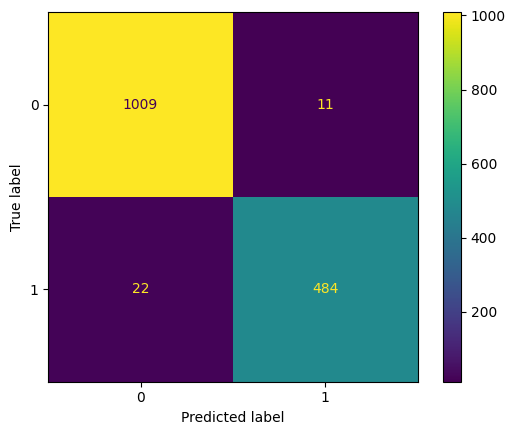

In [79]:
print("Logistic Regression Classification Report:\n")
print(classification_report(test_data["is_spam"], y_pred_logistic_regression, target_names=["ham", "spam"]))
disp = ConfusionMatrixDisplay(confusion_matrix(test_data["is_spam"], y_pred_logistic_regression))
disp.plot()
plt.show()

MLP Classification Report:

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1020
        spam       0.98      0.95      0.97       506

    accuracy                           0.98      1526
   macro avg       0.98      0.97      0.98      1526
weighted avg       0.98      0.98      0.98      1526



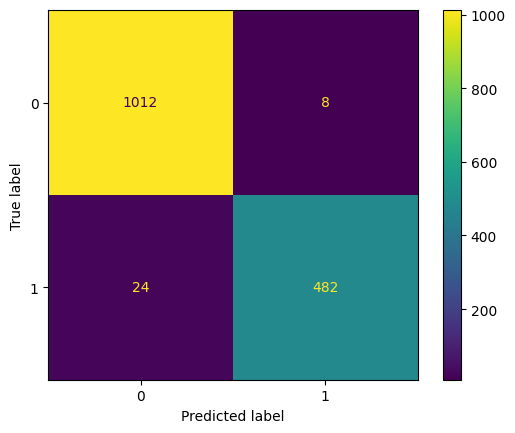

In [80]:
print("MLP Classification Report:\n")
print(classification_report(test_data["is_spam"], y_pred_MLP, target_names=["ham", "spam"]))
disp = ConfusionMatrixDisplay(confusion_matrix(test_data["is_spam"], y_pred_MLP))
disp.plot()
plt.show()

MultinomialNB Classification Report:

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98      1020
        spam       0.99      0.91      0.95       506

    accuracy                           0.97      1526
   macro avg       0.97      0.95      0.96      1526
weighted avg       0.97      0.97      0.97      1526



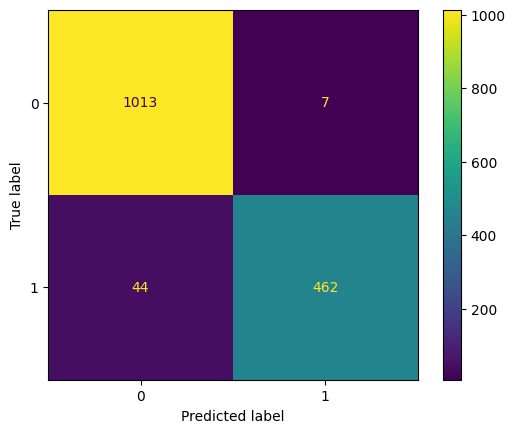

In [81]:
print("MultinomialNB Classification Report:\n")
print(classification_report(test_data["is_spam"], y_pred_mulinomialNB, target_names=["ham", "spam"]))
disp = ConfusionMatrixDisplay(confusion_matrix(test_data["is_spam"], y_pred_mulinomialNB))
disp.plot()
plt.show()